In [1]:
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics as m
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

In [2]:
### Quick Matrix Labels
def cf_matrix_labels(cf_matrix):
    
    group_names = ['True Negatives','False Positives','False Negatives','True Positives']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return labels

In [3]:
train_news = pd.read_csv(os.path.join('./Data/train.csv'))
test_news = pd.read_csv(os.path.join('./Data/test.csv'))

test_news.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
print(train_news.shape, test_news.shape)
# planned to merge the dataset but due to imbalanced column we cannot merge them. hence only using the train

(20800, 5) (5200, 4)


In [5]:
""""
m_data =[train_news, test_news] 
merged_data = pd.concat(m_data)
merged_data.shape
merged_data['label'].value_counts()
merged_data['label'].isna().value_counts()

merged_data = merged_data.dropna()
merged_data['label'].isna().value_counts()

X = merged_data.drop('label', axis =1)
y = merged_data['label']
X.shape
y.shape
"""

'"\nm_data =[train_news, test_news] \nmerged_data = pd.concat(m_data)\nmerged_data.shape\nmerged_data[\'label\'].value_counts()\nmerged_data[\'label\'].isna().value_counts()\n\nmerged_data = merged_data.dropna()\nmerged_data[\'label\'].isna().value_counts()\n\nX = merged_data.drop(\'label\', axis =1)\ny = merged_data[\'label\']\nX.shape\ny.shape\n'

In [6]:
train_news['label'].value_counts()
train_news['label'].isna().value_counts()

train_news = train_news.dropna()
train_news['label'].isna().value_counts()

X = train_news.drop('label', axis =1)
y = train_news['label']
X.shape, y.shape

((18285, 4), (18285,))

    We can see that the dataset is balanced with almost equal number of 1.0 and 0.0 labels where 1 specfies the news as real and 0 as fake

In [7]:
train_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
#set the vocab_size
vocab_size = 10000

In [9]:
message = X.copy()
message.reset_index(inplace = True)

In [10]:
message['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

### NLTK usage

In [11]:
import nltk
import re
from nltk.corpus import stopwords

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ndip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []

for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [14]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'ye paid govern troll social media blog forum websit',
 'major leagu soccer argentin find home success new york time',
 'well fargo chief abruptli step new york time',
 'anonym donor pay million releas everyon arrest dakota access pipelin',
 'fbi close hilla

In [15]:
one_hot_rpr = [one_hot(words, vocab_size) for words in corpus]
one_hot_rpr

[[8920, 3558, 9660, 6021, 5165, 9710, 8799, 8902, 8201, 8643],
 [775, 4775, 8046, 1373, 5303, 8631, 2672],
 [757, 4383, 2560, 6027],
 [8329, 8950, 8512, 8554, 1845, 1278],
 [1253, 5303, 1603, 6298, 4778, 9856, 5303, 7999, 7040, 6335],
 [4422,
  6973,
  319,
  3374,
  942,
  7827,
  3174,
  762,
  5485,
  1568,
  9651,
  9694,
  5133,
  2983,
  2672],
 [6737, 7778, 8183, 822, 9748, 6356, 6454, 6321, 2503, 1123, 2830],
 [5568, 9388, 163, 8837, 9716, 7208, 7827, 8434, 2503, 1123, 2830],
 [2009, 6377, 5913, 128, 1787, 7704, 8937, 8981, 7827, 5869],
 [9139, 6087, 6265, 926, 5892, 9915, 6900, 5263],
 [8114, 9338, 4736, 5389, 9406, 6451, 2319, 2076, 4154, 3562, 6544],
 [8554, 9215, 5165, 7704, 7827, 9716],
 [8462, 2755, 440, 2361, 572, 1704, 8580, 592, 5003],
 [6620, 314, 8758, 8082, 3586, 6608, 1443, 2503, 1123, 2830],
 [9471, 8581, 7661, 4678, 6443, 2503, 1123, 2830],
 [1030, 4980, 2351, 6221, 1199, 4885, 1721, 7615, 333, 1549],
 [5044, 4380, 4775],
 [1136, 8396, 7691, 3589, 7827, 9559, 217

In [16]:
len_sentence = 25
embedded_docs = pad_sequences(one_hot_rpr, maxlen=len_sentence, padding = 'post' )
embedded_docs

array([[8920, 3558, 9660, ...,    0,    0,    0],
       [ 775, 4775, 8046, ...,    0,    0,    0],
       [ 757, 4383, 2560, ...,    0,    0,    0],
       ...,
       [  24, 1407, 1979, ...,    0,    0,    0],
       [9001, 9716, 1239, ...,    0,    0,    0],
       [3609, 7021,  234, ...,    0,    0,    0]], dtype=int32)

In [17]:
embedded_docs[0]

array([8920, 3558, 9660, 6021, 5165, 9710, 8799, 8902, 8201, 8643,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

## MODEL without dropout

In [18]:
embedded_features = 40
model = Sequential()
model.add(Embedding(vocab_size, embedded_features, input_length = len_sentence))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
print(model.summary())

2023-03-24 02:00:43.566274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 02:00:43.566499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 02:00:43.581423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 02:00:43.581667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 02:00:43.581842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            400000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
import numpy as np

X_final = np.array(embedded_docs)
y_final = np.array(y)

X_final.shape, y_final.shape

((18285, 25), (18285,))

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 42)

## With Dropout

In [21]:

embedded_features = 40
model1 = Sequential()
model1.add(Embedding(vocab_size, embedded_features, input_length = len_sentence))
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation = 'sigmoid'))
model1.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 40)            400000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              112800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
________________________________________________

In [22]:
model_pipeline = []
model_pipeline.append(model)
model_pipeline.append(model1)

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

model_list = ['Bi-LSTM', 'Bi-LSTM_Dropout']

acuracy_list  = []
auc_list = []
n_precision_list = []
p_precision_list = []

n_recall_list = []
p_recall_list  = []

n_fscore_list = []
p_fscore_list = []

cm_list = []

for models in model_pipeline:
    print("running")
    models.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, batch_size = 16)
    
    print("Metrics")
    y_pred = (models.predict(X_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict = True)
    # acuracy

    acuracy_list.append(report['accuracy'])

    # precision
    n_precision_list.append(report['0']['precision'])
    p_precision_list.append(report['1']['precision'])

    #recall
    n_recall_list.append(report['0']['recall'])
    p_recall_list.append(report['1']['recall'])

    # f1-score
    n_fscore_list.append(report['0']['f1-score'])
    p_fscore_list.append(report['1']['f1-score'])
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
    auc_list.append(round(m.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))

running
Epoch 1/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0946 - accuracy: 0.9655 - val_loss: 0.1849 - val_accuracy: 0.9222
Epoch 2/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0555 - accuracy: 0.9822 - val_loss: 0.2283 - val_accuracy: 0.9211
Epoch 3/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.3111 - val_accuracy: 0.9185
Epoch 4/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.3622 - val_accuracy: 0.9183
Epoch 5/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.4611 - val_accuracy: 0.9163
Epoch 6/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0067 - accuracy: 0.9975 - val_loss: 0.4386 - val_accuracy: 0.9162
Epoch 7/20
800/800 [==============================] - 6s 7ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.5428 - val_accuracy: 0.916

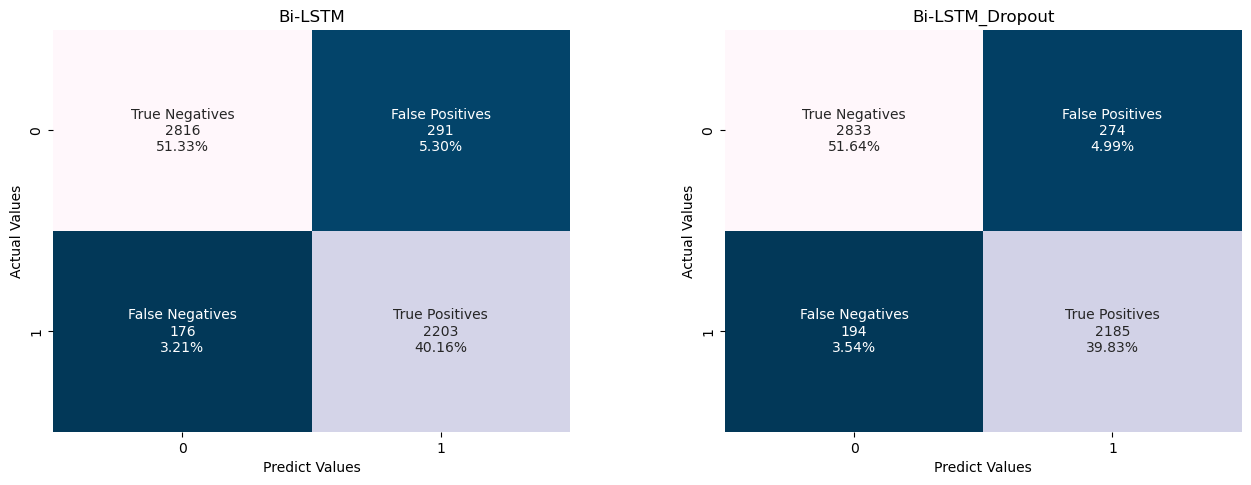

In [25]:


fig = plt.figure(figsize=(24, 12))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    
    sub = fig.add_subplot(2, 3, i+1)
    cm_plot = sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='PuBu_r', cbar=False)
    cm_plot.set_title(model)
    cm_plot.set_xlabel('Predict Values')
    cm_plot.set_ylabel('Actual Values') 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [26]:
df_results = pd.DataFrame({'Model'        : model_list, 
                           'Accuracy'     : acuracy_list, 
                           'Precision (0)': n_precision_list, 
                           'Precision (1)': p_precision_list,
                           'Recall (0)'   : n_recall_list,     
                           'Recall (1)'   : p_recall_list, 
                           'F1-Score (0)' : n_fscore_list ,     
                           'F1-Score (1)' : p_fscore_list})

df_results.style.highlight_max(subset=['Accuracy', 'Precision (0)', 'Precision (1)', 'Recall (0)', 'Recall (1)', 
                                       'F1-Score (0)','F1-Score (1)'], color='lightblue', axis = 0)

,Model,Accuracy,Precision (0),Precision (1),Recall (0),Recall (1),F1-Score (0),F1-Score (1)
0,Bi-LSTM,0.914874,0.941176,0.883320,0.906341,0.926019,0.923430,0.904166
1,Bi-LSTM_Dropout,0.914692,0.935910,0.888573,0.911812,0.918453,0.923704,0.903266
